In [1]:
import numpy as np
import pandas as pd

from torch.utils.data import DataLoader, TensorDataset
from torch.nn.functional import mse_loss
from torch.optim import Adam, SGD, AdamW, Adadelta, Adagrad, Adamax, ASGD, RMSprop, Rprop
from torchmetrics.functional.regression import mean_absolute_error
from lightning import LightningModule, Trainer, LightningDataModule
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import LearningRateMonitor, TQDMProgressBar, LearningRateFinder, StochasticWeightAveraging, RichProgressBar
from torch.optim.lr_scheduler import OneCycleLR, ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau, CyclicLR, LinearLR, StepLR, MultiStepLR
from lightning.pytorch.tuner import Tuner
import torch.onnx

import tsai.models.XResNet1dPlus

import json
import seaborn as sns
import seaborn.objects as so
sns.set_theme()

%load_ext tensorboard


# Models 

In [2]:
xresnets = {
    "xresnet1d18plus": tsai.models.XResNet1dPlus.xresnet1d18plus,
    "xresnet1d34plus": tsai.models.XResNet1dPlus.xresnet1d34plus,
    "xresnet1d50plus": tsai.models.XResNet1dPlus.xresnet1d50plus,
    "xresnet1d101plus": tsai.models.XResNet1dPlus.xresnet1d101plus,
    "xresnet1d152plus": tsai.models.XResNet1dPlus.xresnet1d152plus,
    "xresnet1d18_deepplus": tsai.models.XResNet1dPlus.xresnet1d18_deepplus,
    "xresnet1d34_deepplus": tsai.models.XResNet1dPlus.xresnet1d34_deepplus,
    "xresnet1d50_deepplus": tsai.models.XResNet1dPlus.xresnet1d50_deepplus,
    "xresnet1d18_deeperplus": tsai.models.XResNet1dPlus.xresnet1d18_deeperplus,
    "xresnet1d34_deeperplus": tsai.models.XResNet1dPlus.xresnet1d34_deeperplus,
    "xresnet1d50_deeperplus": tsai.models.XResNet1dPlus.xresnet1d50_deeperplus,
}

def load_model(arch,seq_len):
    if arch in xresnets:
        model = xresnets[arch](1,2,seq_len) 
    else:
        raise ValueError("Unsupported archticture")
    return model.to("mps")

# Dataset

In [3]:
class CSPDataModule(LightningDataModule):
    def __init__(self, json_file, batch_size = 32, num_workers=0, transform=None, frequency=3000, max_time = .5, test_copies=1):
        super().__init__()
        self.json_file = json_file
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform
        self.frequency = frequency
        self.max_time = max_time
        self.test_copies = test_copies

    def prepare_data(self):
        with open(self.json_file) as f:
          self.data=json.load(f)
          self.indices = {"test":[], "train":[], "exclude":[]}
          for i,d in enumerate(self.data):
            self.indices[d["split"]].append(i)
          max_index = int(self.frequency*self.max_time)
          self.signals = torch.unsqueeze(torch.tensor(np.array([d["signal"] for d in self.data],dtype=np.float32)[:,:max_index]*1000),dim=1)
          self.csps = torch.tensor(np.array([d["csp_label"] for d in self.data],dtype=np.float32)/self.max_time)
          self.labels = np.array([f'#{d["id"]}' for d in self.data])
          self.label_indices = torch.tensor(range(len(self.labels)))
          self.split = np.array([d["split"] for d in self.data])
          self.split_name_to_index = {name: idx for idx,name in enumerate(np.unique(self.split))}
          self.split_index_to_name = {idx: name for idx,name in enumerate(np.unique(self.split))}
          self.split_indices = torch.tensor([self.split_name_to_index[name] for name in self.split])
          self.time_range = np.array([0,self.max_time])


    def setup(self, stage="fit"):
        if stage == "fit":
            self.train_data = TensorDataset(self.signals[self.indices["train"]], self.csps[self.indices["train"]])
            self.val_data = TensorDataset(self.signals[self.indices["test"]],self.csps[self.indices["test"]])
                        
        elif stage == "test":
            self.test_data =  TensorDataset(self.signals.repeat_interleave(self.test_copies, dim=0), self.csps.repeat_interleave(self.test_copies, dim=0), self.label_indices.repeat_interleave(self.test_copies, dim=0), self.split_indices.repeat_interleave(self.test_copies, dim=0))
        
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def on_before_batch_transfer(self, batch, dataloader_idx):
        if self.transform:
            batch = self.transform(batch)
        return batch
    
    def teardown(self, stage: str):
        # Used to clean-up when the run is finished
        pass

In [4]:
def random_resize(to=512):
    def transform(batch):
        if len(batch)==2:
            x,y = batch
            p = []
        else:
            x,y,*p = batch
        length = x.shape[2]
        min_time, max_time = y[:,0].min(), y[:,1].max()
        start_index = torch.randint(low=0, high=int(.8*min_time*length), size=(1,)).item()
        end_index = torch.randint(low=int(1.2*max_time*length), high=length, size=(1,)).item()
        start_time, end_time = start_index/length, end_index/length
        x_transform = torch.nn.functional.interpolate(x[:,:,start_index:end_index], size=(to,),mode="linear",align_corners=True) 
        y_transform = (y-start_time)/(end_time-start_time)
        print(x.shape,x_transform.shape)
        return x_transform, y_transform, *p
    return transform

In [5]:
def signal_augmentation(to=512, shift_mag=.2, scale_mag=3., drift_mag=.2, noise_mag=1e-3, center_csp=True):
    def transform(batch):
        if len(batch)==2:
            x,y = batch
            p = []
        else:
            x,y,*p = batch
        length = x.shape[2]
        x_transform, y_transform = torch.zeros((x.shape[0],1,to)), torch.zeros((x.shape[0],2))
        if p:
            time_transform = torch.zeros((x.shape[0],2))
        for i,(signal, label) in enumerate(zip(x,y)):
            end = (length*(1-label[0]-label[1])/2).int() if center_csp else 0
            signal[0] = torch.concat((signal[0,-end:],signal[0,:-end]))
            label += end/length
            start_index = torch.randint(low=0, high=int(.8*length*label[0]), size=(1,)).item()
            end_index = torch.randint(low=int(1.2*length*label[1]), high=length, size=(1,)).item()
            start_time, end_time = start_index/length, end_index/length
            if p:
                time_transform[i] = torch.tensor([start_time-end/length, end_time-end/length])
            x_transform[i,0] = torch.nn.functional.interpolate(signal[:,start_index:end_index].unsqueeze(1), size=(to,),mode="linear",align_corners=True)
            scale_factor = 1/scale_mag + torch.rand((1,)).item() *(scale_mag - 1/scale_mag)
            shift_factor = 2*(torch.rand((1,)).item() - .5)*shift_mag
            drift_factor = 2*(torch.rand((1,)).item() - .5)*drift_mag
            x_transform[i,0] *= scale_factor
            x_transform[i,0] += drift_factor * torch.linspace(0,1,to) + shift_factor + noise_mag*torch.randn((to,))
            y_transform[i] = (label-start_time)/(end_time-start_time)
        if p:
            return x_transform, y_transform, *p, time_transform
        return x_transform, y_transform, *p
    return transform

In [6]:
def dataset_to_df(dataset):
    data=dataset[:]
    x,y=data[:2]
    idx,split = None, None
    if len(data)>=4:
        idx,split = data[2:4]
        idx = idx.detach().numpy().tolist()
        split = split.detach().numpy().tolist()
    signal = x.detach().numpy()[:,0].tolist()
    time = np.linspace(0,1,x.shape[2])
    csp = y.detach().numpy().tolist()
    df = pd.DataFrame({"signal": signal, "csp": csp, "idx": idx, "split": split})
    df['time'] = df.apply(lambda x: time, axis=1)
    return df

def plot(df,markers={}):
    df=df.explode(["signal","time"]).reset_index()
    for name in markers.keys():
        df=pd.concat([df,pd.DataFrame(df[name].tolist(),columns=[name+"_on",name+"_off"])],axis=1)
    g = (
        so.Plot(data=df, x="time", y="signal")
        .add(so.Line())
        .facet(row="index")
        .limit(y=(-1, 1))
    )
    for name,color in markers.items():
        g = g.add(so.Range(color=color), x=name+"_on", ymin=-1, ymax=1).add(so.Range(color=color), x=name+"_off", ymin=-1, ymax=1)
    return g

tensor([[0.0980, 0.3613],
        [0.1200, 0.4727],
        [0.0947, 0.2933],
        [0.1113, 0.2320],
        [0.1207, 0.3213]])
tensor([[0.3300, 0.7310],
        [0.2010, 0.6441],
        [0.3225, 0.6694],
        [0.4366, 0.5928],
        [0.1407, 0.4714]]) tensor([[-0.1187,  0.5380],
        [-0.0400,  0.7560],
        [-0.0900,  0.4827],
        [-0.2260,  0.5467],
        [ 0.0353,  0.6420]])
tensor([[0.0980, 0.3613],
        [0.1200, 0.4727],
        [0.0947, 0.2933],
        [0.1113, 0.2320],
        [0.1207, 0.3213]])


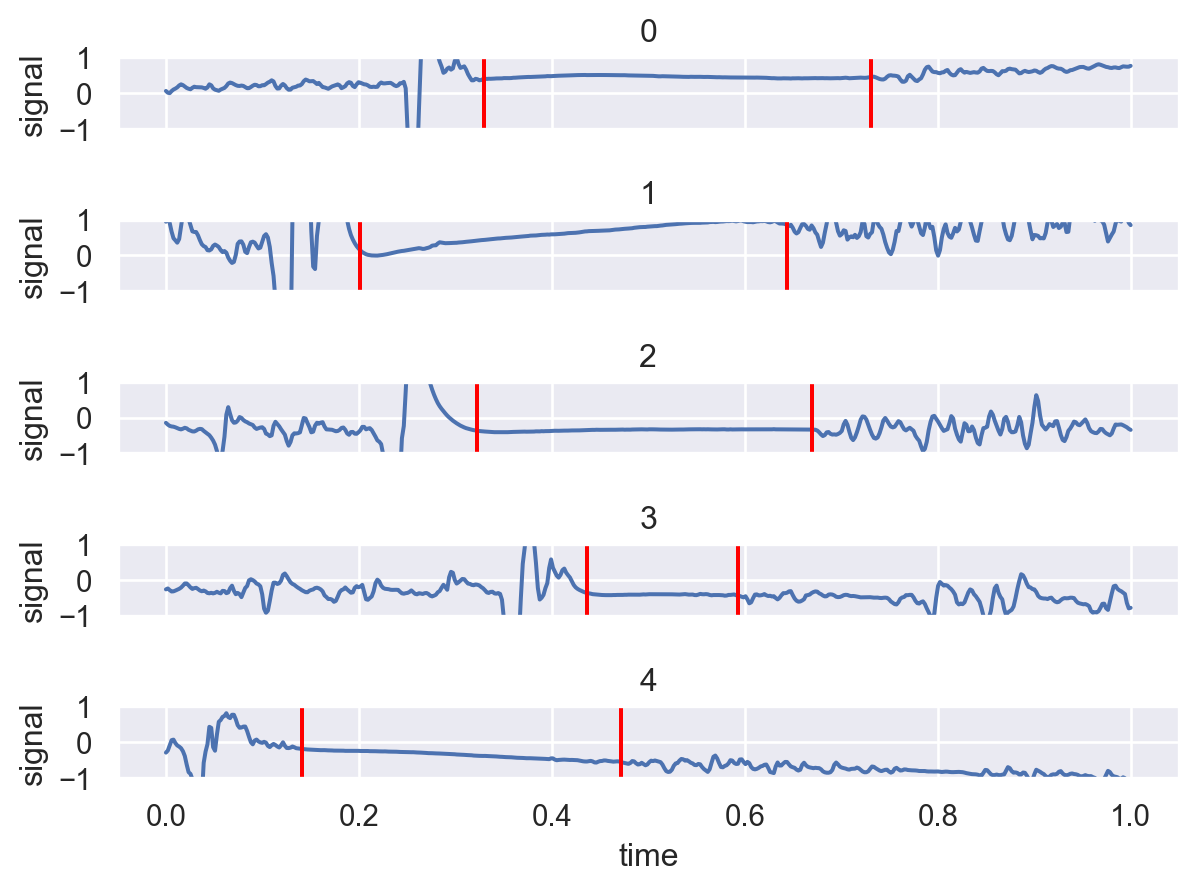

In [7]:
cspdata = CSPDataModule("all_data.json", batch_size=5, num_workers=0, transform=signal_augmentation(to=512, shift_mag=.5, scale_mag=2., drift_mag=1, noise_mag=.001, center_csp=True), frequency=3000, max_time = .5, )
cspdata.prepare_data()
cspdata.setup("test")
batch = next(iter(cspdata.test_dataloader()))
print(batch[1])
batch = cspdata.on_before_batch_transfer(batch,0)
print(batch[1],batch[4])
start_time, time_length = batch[4][:,0], batch[4][:,1]-batch[4][:,0]
print((batch[1]*time_length.unsqueeze(dim=1)+start_time.unsqueeze(dim=1)))
df = dataset_to_df(batch)
plot(df,markers={"csp":"red"})

# Learner

In [34]:
class CSPLearner(LightningModule):
    def __init__(self, model, test_every=None, **kwargs):
        super().__init__()
        self.save_hyperparameters(ignore=['model','test_every'])
        self.model = model
        self.test_every = test_every

    def forward(self, x):
        out = self.model(x)
        return out

    def evaluate(self, batch, stage=None):
        x, y, *_ = batch
        z = self(x)
        loss = mse_loss(y, z)
        mae = mean_absolute_error(y,z)

        if stage is not None:
            self.log(f"{stage}/loss", loss, prog_bar=True, on_step=False, on_epoch=True)
            self.log(f"{stage}/mae", mae, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self.evaluate(batch, stage="train")

    def validation_step(self, batch, batch_idx):
        return self.evaluate(batch, stage="val")
    
    def on_test_epoch_start(self) -> None:
        self.test_pred = {"csp": [], "csp_pred": [], "idx": [], "split": [], "real_csp_pred":[], "real_csp": []}
        return super().on_test_epoch_start()
    
    def on_validation_epoch_end(self) -> None:
        if self.test_every is not None and self.current_epoch%self.test_every == 1:
            self.trainer.datamodule.setup("test")
            self.on_test_epoch_start()
            for batch in self.trainer.datamodule.test_dataloader():
                batchT = self.trainer.datamodule.on_before_batch_transfer(batch, dataloader_idx=0)
                batchT = self.trainer.datamodule.transfer_batch_to_device(batchT, self.device, dataloader_idx=0)
                batchT = self.trainer.datamodule.on_after_batch_transfer(batchT, dataloader_idx=0)
                self.test_step(batchT, None)
            self.on_test_epoch_end()
            self.trainer.datamodule.setup("fit")
        return super().on_validation_end()
    
    def on_test_epoch_end(self) -> None:
        df=pd.DataFrame(self.test_pred)
        df=df.explode(["csp","csp_pred","real_csp","real_csp_pred"])
        df["type"] = ["on","off"]*(len(df)//2)
        df = df.groupby(["idx","type"]).agg({"real_csp": "mean", "real_csp_pred": ["mean","std"], "split": "first"}).reset_index()
        df["pred_error"] = df[("real_csp","mean")]-df[("real_csp_pred","mean")]
        g=(
            so.Plot(data=df, x=("real_csp","mean"), y="pred_error", color=("real_csp_pred","std"))
            .scale(color=so.Continuous("ch:.2", norm=(0,.1)))
            .facet(("split","first"),"type")
            .limit(y=(-.1, .1))
            .add(so.Dot())
        )
        self.logger.experiment.add_figure("scatter", g.plot()._figure, self.current_epoch)
        for (s,typ),vals in df.groupby([("split","first"),"type"])["pred_error"].agg(list).items():
            self.logger.experiment.add_histogram(f"{s}/hist/{typ}", np.array(vals), self.current_epoch)
        df["abs_pred_error"] = np.abs(df[("real_csp","mean")]-df[("real_csp_pred","mean")])
        df["pred_fluct"] = df[("real_csp_pred","std")]
        dicErr = { f"{s}/predErr/{typ}": num for (s,typ),num in df.groupby([("split","first"),"type"])["abs_pred_error"].mean().items() }
        dicStd = { f"{s}/predStd/{typ}": num for (s,typ),num in df.groupby([("split","first"),"type"])["pred_fluct"].mean().items() }
        self.log_dict({**dicErr, **dicStd})

    def test_step(self, batch, batch_idx):
        x, y, idx, split, time_transform = batch
        z = self(x)
        self.test_pred["csp"] += y.detach().cpu().numpy().tolist()
        self.test_pred["csp_pred"] += z.detach().cpu().numpy().tolist()
        start_time, time_length = time_transform[:,0], time_transform[:,1]-time_transform[:,0]
        self.test_pred["real_csp"] += (y*time_length.unsqueeze(dim=1)+start_time.unsqueeze(dim=1)).detach().cpu().numpy().tolist()
        self.test_pred["real_csp_pred"] += (z*time_length.unsqueeze(dim=1)+start_time.unsqueeze(dim=1)).detach().cpu().numpy().tolist()
        self.test_pred["idx"] += idx.detach().cpu().numpy().tolist()
        self.test_pred["split"] += [self.trainer.datamodule.split_index_to_name[i] for i in split.detach().cpu().numpy()]
        return super().test_step(batch, batch_idx)
    
    def on_train_start(self):
        self.logger.log_hyperparams(self.hparams, {"val/loss": 1, "train/loss": 1})
        return super().on_train_start()

    def configure_optimizers(self):
        optimizer = self.hparams.Optimizer(
            self.parameters(),
            lr=self.hparams.lr,
            **self.hparams.optimizer_kwargs,
        )
        
        scheduler = self.hparams.Scheduler(optimizer, **self.hparams.scheduler_kwargs) if self.hparams.Scheduler is not None else None
        
        return {"optimizer": optimizer, **({"lr_scheduler": scheduler} if scheduler is not None else {})}


# Training

In [37]:
window_size = 256
batch_size  = 32
lr = 1e-3
lr_end = 1e-4
epochs = 10000
arch = "xresnet1d18plus"
accumulate_grad_batches = 4
test_copies = 5
test_every = 100
shift_mag = .2
scale_mag = 2.
drift_mag = 1e-4
noise_mag = 1e-5
center_csp = True
swa_epoch_start = .8
Optimizer = AdamW
optimizer_kwargs = {"eps": 1e-7, }
#Scheduler = OneCycleLR
#scheduler_kwargs = {"max_lr": lr, "epochs": epochs, "steps_per_epoch": 1, "three_phase": False }
Scheduler = None
scheduler_kwargs = None#{"step_size": 100, "gamma": .5}

gamma = (lr_end/lr)**(1/epochs) # lr * gamma^epochs = lr_end => gamma = (lr_end/lr)^(1/epochs)


model = load_model(arch, window_size)

cspdata = CSPDataModule(
        "all_data.json", 
        batch_size = batch_size, 
        num_workers = 0, 
        transform = signal_augmentation(
            to=window_size, 
            shift_mag=shift_mag, 
            scale_mag=scale_mag, 
            drift_mag=drift_mag, 
            noise_mag=noise_mag, 
            center_csp=center_csp),
        test_copies=test_copies
        )

learner = CSPLearner(
        model, 
        lr=lr, 
        batch_size=batch_size, 
        window_size=window_size, 
        epochs=epochs, 
        accumulate_grad_batches=accumulate_grad_batches, 
        test_every = test_every,
        test_copies = test_copies,
        shift_mag=shift_mag, 
        scale_mag=scale_mag, 
        drift_mag=drift_mag,
        noise_mag=noise_mag,
        center_csp=center_csp,
        swa_epoch_start=swa_epoch_start,
        swa_lrs=lr_end,
        Optimizer=Optimizer,
        optimizer_kwargs=optimizer_kwargs,
        Scheduler=Scheduler,
        scheduler_kwargs=scheduler_kwargs,
        )

trainer = Trainer(
        default_root_dir="lightning-checkpoints/",
        num_sanity_val_steps=0,
        max_epochs=epochs,
        accelerator="auto",
        devices=1,
        logger=TensorBoardLogger("lightning_logs", name=arch, default_hp_metric=False),
        callbacks=[
            LearningRateMonitor(logging_interval="epoch"), 
            LearningRateFinder(),
            RichProgressBar(), 
            StochasticWeightAveraging(swa_lrs=lr_end,swa_epoch_start=swa_epoch_start),
            ],
        log_every_n_steps=1,
        profiler="simple",
        accumulate_grad_batches=accumulate_grad_batches,
    )

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [39]:
trainer = Trainer(
        num_sanity_val_steps=0,
        max_epochs=epochs+1000,
        accelerator="auto",
        devices=1,
        logger=TensorBoardLogger("lightning_logs", name=arch, default_hp_metric=False),
        callbacks=[
            LearningRateMonitor(logging_interval="epoch"), 
            LearningRateFinder(),
            RichProgressBar(), 
            StochasticWeightAveraging(swa_lrs=lr_end,swa_epoch_start=swa_epoch_start),
            ],
        log_every_n_steps=1,
        profiler="simple",
        accumulate_grad_batches=accumulate_grad_batches,
    )

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [40]:
trainer.fit(learner, cspdata)

/Users/dschroeder/miniconda3/envs/ml/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/dschroeder/miniconda3/envs/ml/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 67 steps due to diverging loss.
Learning rate set to 5.248074602497728e-06
Restoring states from the checkpoint path at /Users/dschroeder/Documents/csp/.lr_find_80fd7a0f-6f01-4bbd-bccd-f420a685c1d9.ckpt
Restored all states from the checkpoint at /Users/dschroeder/Documents/csp/.lr_find_80fd7a0f-6f01-4bbd-bccd-f420a685c1d9.ckpt


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type          ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model │ XResNet1dPlus │  3.9 M │
└───┴───────┴───────────────┴────────┘

Trainable params: 3.9 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.9 M                                                                                                
Total estimated model params size (MB): 15

Restored all states from the checkpoint at /Users/dschroeder/Documents/csp/.lr_find_80fd7a0f-6f01-4bbd-bccd-f420a685c1d9.ckpt


Output()

/Users/dschroeder/miniconda3/envs/ml/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


`Trainer.fit` stopped: `max_epochs=11001` reached.


FIT Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  5914854        	|

In [36]:
trainer.test(learner, datamodule=cspdata)

Output()

/Users/dschroeder/miniconda3/envs/ml/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    exclude/predErr/off    │    0.40823420882225037    │
│    exclude/predErr/on     │    0.20265263319015503    │
│    exclude/predStd/off    │    0.08397988975048065    │
│    exclude/predStd/on     │    0.0754147619009018     │
│     test/predErr/off      │    0.4541727900505066     │
│      test/predErr/on      │    0.16709819436073303    │
│     test/predStd/off      │    0.08442100882530212    │
│      test/predStd/on      │    0.07769443094730377    │
│     train/predErr/off     │    0.46746712923049927    │
│     train/predErr/on      │    0.18021830916404724    │
│     train/predStd/off     │    0.08767296373844147    │
│     train/predStd/on      │    0.08109074085950851    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                   	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                    	|  -              	|  622            	|  2.7079         	|  100 % 

[{'exclude/predErr/off': 0.40823420882225037,
  'exclude/predErr/on': 0.20265263319015503,
  'test/predErr/off': 0.4541727900505066,
  'test/predErr/on': 0.16709819436073303,
  'train/predErr/off': 0.46746712923049927,
  'train/predErr/on': 0.18021830916404724,
  'exclude/predStd/off': 0.08397988975048065,
  'exclude/predStd/on': 0.0754147619009018,
  'test/predStd/off': 0.08442100882530212,
  'test/predStd/on': 0.07769443094730377,
  'train/predStd/off': 0.08767296373844147,
  'train/predStd/on': 0.08109074085950851}]

# Evaluation

In [338]:
trainer.test(learner, cspdata)

/Users/dschroeder/miniconda3/envs/ml/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

          error          
           mean       std
split                    
0      0.055489  0.080949
1      0.012598  0.029899
2      0.004951  0.004983


[{}]

In [213]:
np.array(list(cspdata.split_names.keys()))

array(['exclude', 'test', 'train'], dtype='<U7')

error          
             mean       std
split                      
exclude  0.162733  0.132108
test     0.213524  0.149176
train    0.210947  0.152950

In [78]:
def train(
        batch_size=128, 
        epochs=500, 
        lr=1e-4, 
        arch="xresnet1d18plus", 
        window_size=256, 
        accumulate_grad_batches=1, 
        swa_lr=None, 
        max_lr = 1e-2
        ):

    cspdata = CSPDataModule(
        "all_data.json", 
        batch_size=batch_size, 
        num_workers=0, 
        transform=random_resize(to=window_size)
        )
    
    model = load_model(arch, window_size)

    learner = CSPLearner(
        model, 
        lr=lr, 
        batch_size=batch_size, 
        window_size=window_size, 
        epochs=epochs, 
        accumulate_grad_batches=accumulate_grad_batches, 
        max_lr = max_lr,
        momentum = 0,
        weight_decay = 0,
        three_phase = False,
        gamma = 
        )
    
    trainer = Trainer(
        max_epochs=epochs,
        accelerator="auto",
        devices=1,
        logger=TensorBoardLogger("lightning_logs", name=arch, default_hp_metric=False),
        callbacks=[
            LearningRateMonitor(logging_interval="epoch"), 
            TQDMProgressBar(refresh_rate=10), 
            StochasticWeightAveraging(swa_lrs=swa_lr) if swa_lr else None,
            ],
        log_every_n_steps=1,
        #profiler="simple",
        accumulate_grad_batches=accumulate_grad_batches,
    )
    trainer.fit(learner, cspdata)